# **03. Modelling and Evaluation**

## Objectives

* Predict if a given cherry leaf is infected with powdery mildew or not.

## Inputs

* inputs/cherry_leaf_dataset/cherry-leaves/train
* inputs/cherry_leaf_dataset/cherry-leaves/validation
* inputs/cherry_leaf_dataset/cherry-leaves/test
* image shape embedding

## Outputs

* Images distribution plot in train, vlidation and test datasets.
* Image aumentation
* Class indices to change prediction inference in labels.
* Create, train and save a machine learning model.
* Learning curve plot for model performance.
* Model evaluation.
* Check model prediction.



## Additional Comments

* These modelling and evaluation steps will fulfill business requirement 2.




# Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Set Working Directory

In [4]:
cwd= os.getcwd()

In [5]:
os.chdir('/workspaces/Mildew_Detection_in_Cherry_Leaves')
print("You set a new current directory")

You set a new current directory


In [6]:
work_dir = os.getcwd()
work_dir

'/workspaces/Mildew_Detection_in_Cherry_Leaves'

Set input directories

In [7]:
my_data_dir = 'inputs/cherry_leaf_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Set output directory

In [8]:
version = 'v5'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Set label names

In [9]:
labels = os.listdir(train_path)
print('The images labels are', labels)

The images labels are ['healthy', 'powdery_mildew']


Set image shape

In [10]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

# Image Distribution in Datasets

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




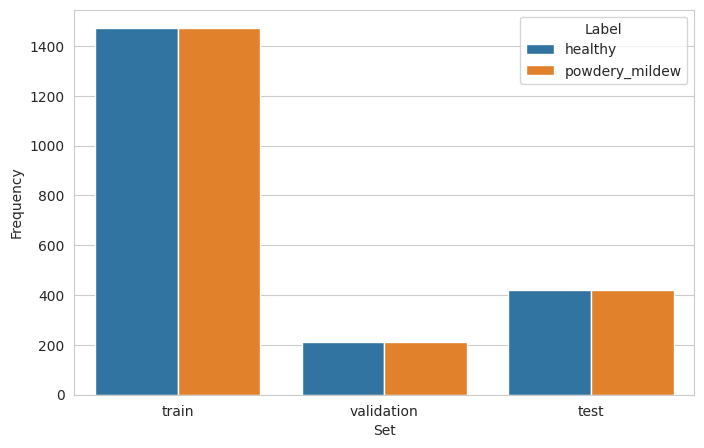

In [11]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

# Image Augmentation

As the dataset contains 4208 images, image augmentation will be used to create a larger image pool.

Import Libraries

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

Augment the training image dataset

In [13]:
batch_size = 20
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment the validation image dataset

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment the test image dataset

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot augmented training images

(64, 256, 256, 3)


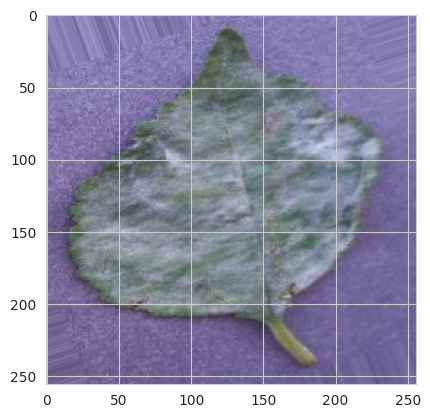

(64, 256, 256, 3)


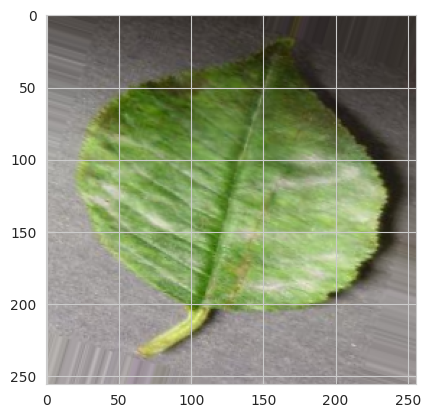

(64, 256, 256, 3)


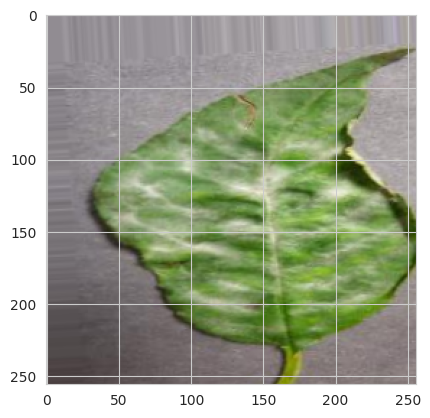

In [16]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Plot augmented validation images

(64, 256, 256, 3)


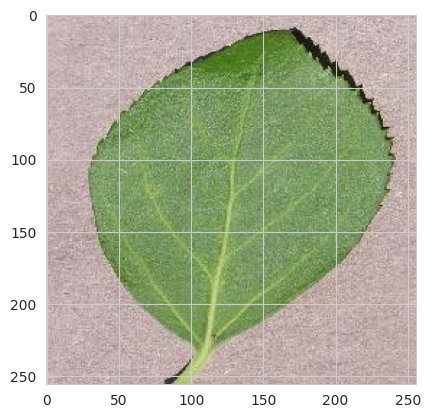

(64, 256, 256, 3)


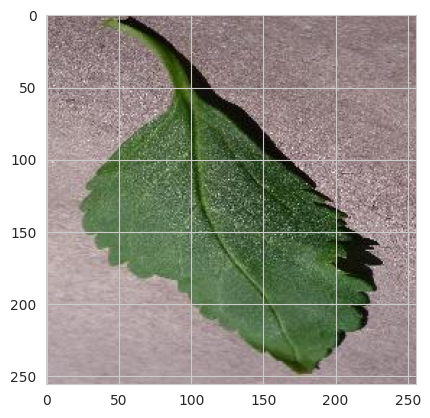

(64, 256, 256, 3)


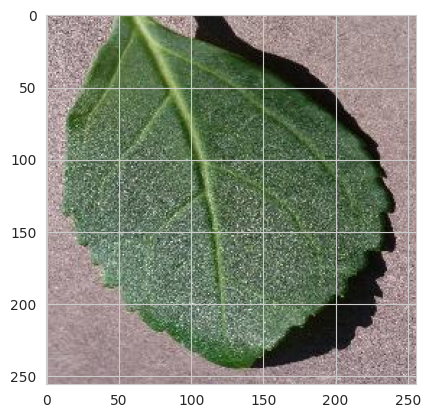

In [17]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Plot augmented test images

(64, 256, 256, 3)


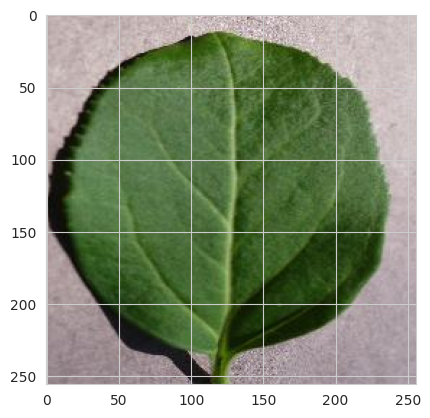

(64, 256, 256, 3)


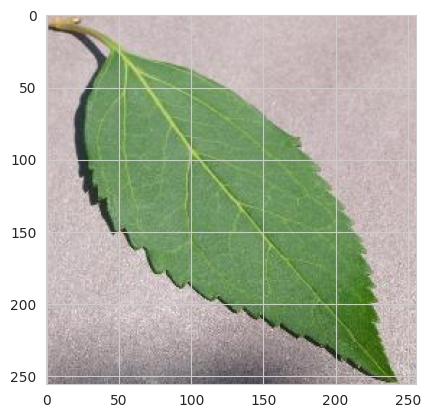

(64, 256, 256, 3)


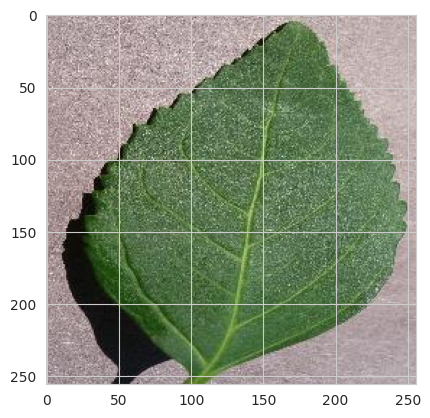

In [18]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Save class_indices

In [19]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v6/class_indices.pkl']

# Model Creation

Import Libraries

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Model

In [20]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(5,5),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))

    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

Model Summary

In [21]:
create_tf_model().summary()

2023-05-09 19:54:32.989283: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
____________________________________________

Early stopping

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

Fit model for model training

In [23]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2023-05-09 18:50:26.509136: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Epoch 1/25
92/92 [==============================] - 241s 2s/step - loss: 0.4776 - accuracy: 0.7565 - val_loss: 0.1083 - val_accuracy: 0.9714
Epoch 2/25
92/92 [==============================] - 195s 2s/step - loss: 0.1292 - accuracy: 0.9579 - val_loss: 0.0350 - val_accuracy: 0.9929
Epoch 3/25
92/92 [==============================] - 191s 2s/step - loss: 0.0745 - accuracy: 0.9769 - val_loss: 0.0250 - val_accuracy: 0.9952
Epoch 4/25
92/92 [==============================] - 193s 2s/step - loss: 0.1265 - accuracy: 0.9701 - val_loss: 0.0837 - val_accuracy: 0.9762
Epoch 5/25
92/92 [==============================] - 191s 2s/step - loss: 0.1147 - accuracy: 0.9738 - val_loss: 0.0179 - val_accuracy: 0.9976
Epoch 6/25
92/92 [==============================] - 191s 2s/step - loss: 0.0536 - accuracy: 0.9817 - val_loss: 0.0167 - val_accuracy: 0.997

Save model

In [24]:
model.save('outputs/v5/mildew_detector_model.h5')

# Model Performance

## Model Learning Curve

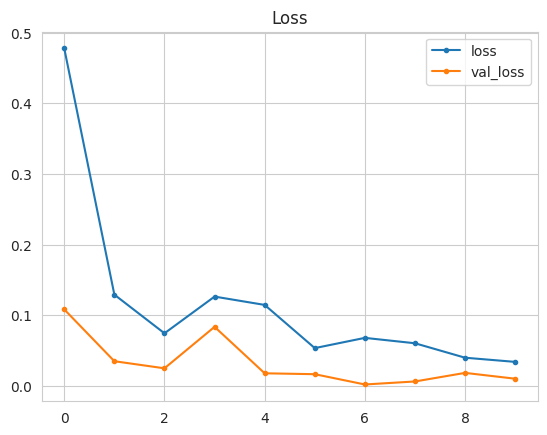

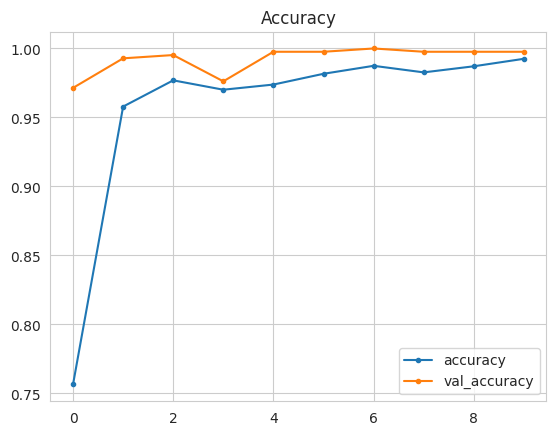

In [25]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Load saved model

In [26]:
from keras.models import load_model
model = load_model('outputs/v5/mildew_detector_model.h5')

Evaluate model on test set

In [27]:
evaluation = model.evaluate(test_set)

27/27 [==============================] - 12s 434ms/step - loss: 7.4826e-04 - accuracy: 1.0000


Save evaluation

In [28]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v5/evaluation.pkl")

['outputs/v7/evaluation.pkl']

## Predict on New Data

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


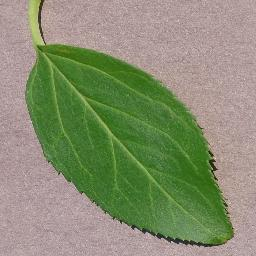

In [29]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[0]

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [30]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [31]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9999990379417341
healthy


# Conclusions and Next Steps

* Image augmentation was performed.
* Model was created and evaluated.
* As the validation and training plots follow a similar path, the data hasn't underfitted or overfitted.
* The model has exceeded the business requirement of 97% prediction accuracy.
* The model can accurately predict whether an image can be classified as healthy or containing powdery mildew.